In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 1. Загрузка данных

In [ ]:
data = pd.read_csv(f"data_lec.csv")
target = pd.read_csv(f"target_lec.csv")

# Объединяем данные и таргет по времени
full_data = data.copy()
full_data['target'] = target['target']

# Проверка данных
print(full_data.describe())

# Преобразование timestamp в datetime
if 'timestamp' in full_data.columns:
    full_data['timestamp'] = pd.to_datetime(full_data['timestamp'], errors='coerce')
    full_data.sort_values('timestamp', inplace=True)
    full_data.reset_index(drop=True, inplace=True)
    full_data.set_index(full_data['timestamp'], inplace=True)
    full_data.drop(columns=['timestamp'], inplace=True)

# Заполнение пропусков
full_data = full_data.fillna(full_data.median())

         Unnamed: 0          ppm1         temp1         temp2          ppm2  \
count  81255.000000  80284.000000  80639.000000  80639.000000  80284.000000   
mean   40627.000000   1497.049701    759.162893    824.706563      8.584342   
std    23456.442399    608.930252    162.119881    212.539937      4.409426   
min        0.000000  -1691.106445     -1.000000     -1.000000    -22.222222   
25%    20313.500000   1340.092102    771.698669    842.664917      5.843099   
50%    40627.000000   1732.878296    799.317749    887.951218      7.262732   
75%    60940.500000   1955.211700    821.107323    925.007709      9.527362   
max    81254.000000   2005.786255   1006.608124   1063.934143     21.554904   

       gas_opening1        press1  rotationspeed1        press3         temp3  \
count  80639.000000  80639.000000    80639.000000  80639.000000  80639.000000   
mean      68.754007     63.349714       20.227902     88.044516     23.428025   
std       20.948000     19.816016       25.33

In [ ]:
print(full_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81255 entries, 2023-09-04 05:01:00+00:00 to 2023-10-30 05:00:00+00:00
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              81255 non-null  int64  
 1   ppm1                    81255 non-null  float64
 2   temp1                   81255 non-null  float64
 3   temp2                   81255 non-null  float64
 4   ppm2                    81255 non-null  float64
 5   gas_opening1            81255 non-null  float64
 6   press1                  81255 non-null  float64
 7   rotationspeed1          81255 non-null  float64
 8   press3                  81255 non-null  float64
 9   temp3                   81255 non-null  float64
 10  press2                  81255 non-null  float64
 11  press4                  81255 non-null  float64
 12  temp4                   81255 non-null  float64
 13  electric_ampere1        81255 non-null  floa

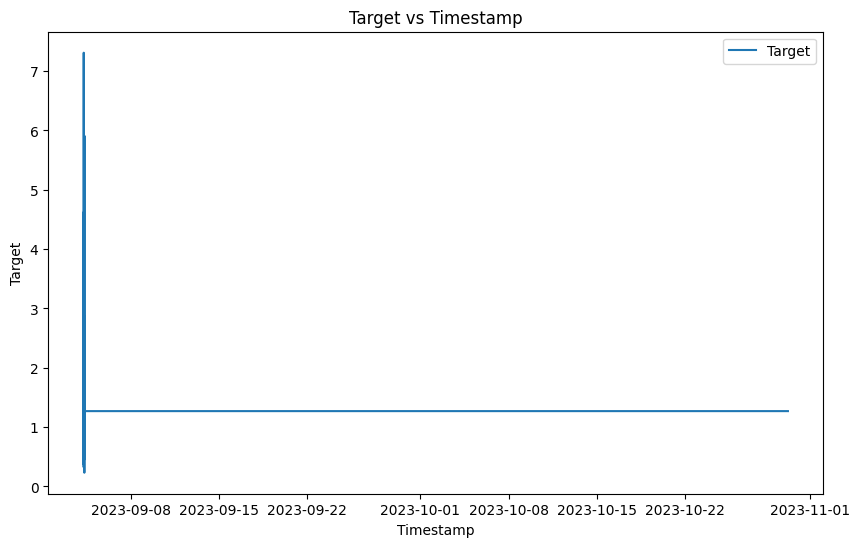

In [ ]:
# Визуализация зависимости target от timestamp
plt.figure(figsize=(10, 6))
plt.plot(full_data.index, full_data['target'], label="Target")
plt.xlabel("Timestamp")
plt.ylabel("Target")
plt.title("Target vs Timestamp")
plt.legend()
plt.show()

Видно, что сам по себе timestemp не особо информативен. Он будет мешать при обучении. Сделал его индексом т.к. идет равномерну каждую минуту

# 2. Построение виртуального датчика

MAE: 0.1731126239743193
MSE: 0.13629289313432835


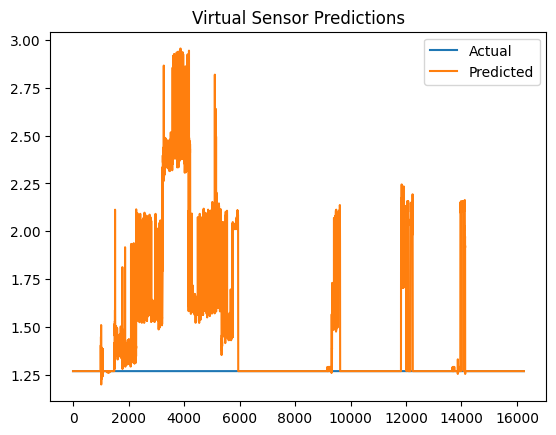

In [ ]:
# Разделение данных на признаки и таргет
X = full_data.drop(columns=['target'])
y = full_data['target']

# Разделение на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Обучение модели (в качестве предсказателя возьмем случайный лес как бейзлайн)
vd_model = RandomForestRegressor(n_estimators=100, random_state=42)
vd_model.fit(X_train, y_train)

# Оценка качества
vd_predictions = vd_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, vd_predictions))
print("MSE:", mean_squared_error(y_test, vd_predictions))

# Визуализация
plt.plot(y_test.values, label="Actual")
plt.plot(vd_predictions, label="Predicted")
plt.legend()
plt.title("Virtual Sensor Predictions")
plt.show()

Предсказания не очень хорошие, но и не такие плохие. Большую часть времени таргет имеет одинаковое значение.

Learning rate set to 0.079182
0:	learn: 0.0465072	total: 27.4ms	remaining: 27.3s
1:	learn: 0.0457643	total: 52.1ms	remaining: 26s
2:	learn: 0.0450832	total: 77.1ms	remaining: 25.6s
3:	learn: 0.0442347	total: 103ms	remaining: 25.6s
4:	learn: 0.0436033	total: 125ms	remaining: 24.9s
5:	learn: 0.0430543	total: 153ms	remaining: 25.3s
6:	learn: 0.0423190	total: 180ms	remaining: 25.5s
7:	learn: 0.0417919	total: 211ms	remaining: 26.2s
8:	learn: 0.0412051	total: 234ms	remaining: 25.8s
9:	learn: 0.0407478	total: 257ms	remaining: 25.4s
10:	learn: 0.0401484	total: 281ms	remaining: 25.3s
11:	learn: 0.0396011	total: 303ms	remaining: 25s
12:	learn: 0.0390801	total: 330ms	remaining: 25s
13:	learn: 0.0385387	total: 354ms	remaining: 24.9s
14:	learn: 0.0380337	total: 378ms	remaining: 24.8s
15:	learn: 0.0376558	total: 416ms	remaining: 25.6s
16:	learn: 0.0371504	total: 441ms	remaining: 25.5s
17:	learn: 0.0367362	total: 463ms	remaining: 25.3s
18:	learn: 0.0363300	total: 488ms	remaining: 25.2s
19:	learn: 0.0

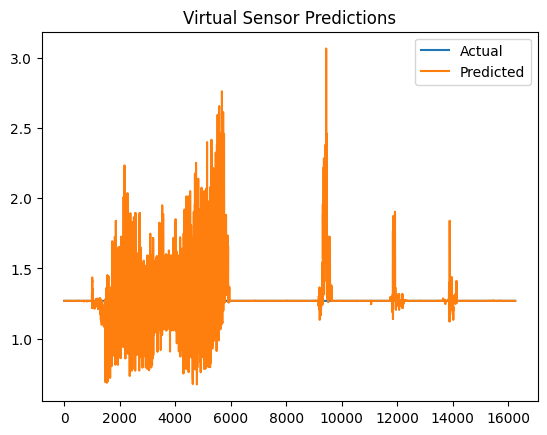

In [ ]:
# Обучение модели
boost_model = CatBoostRegressor()
boost_model.fit(X_train, y_train)

# Оценка качества
boost_predicitons = boost_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, boost_predicitons))
print("MSE:", mean_squared_error(y_test, boost_predicitons))

# Визуализация
plt.plot(y_test.values, label="Actual")
plt.plot(boost_predicitons, label="Predicted")
plt.legend()
plt.title("Virtual Sensor Predictions")
plt.show()

Бустинг справился хуже т.к. переобучился. Попробуем простейшую модель, например регрессию ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet

MAE: 0.01020495038844603
MSE: 0.0002003894169973762


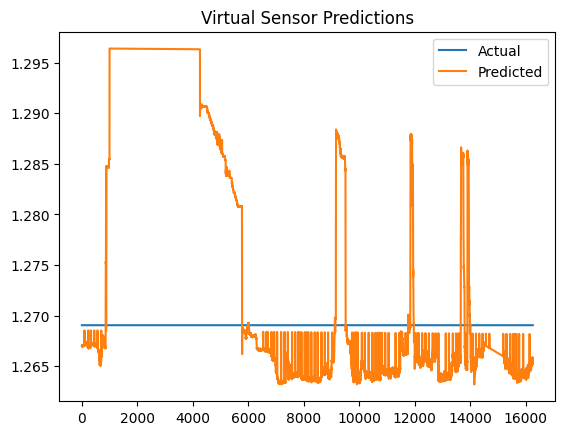

In [ ]:
# Обучение модели
regression_model = ElasticNet()
regression_model.fit(X_train, y_train)

# Оценка качества
regression_predictions = regression_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, regression_predictions))
print("MSE:", mean_squared_error(y_test, regression_predictions))

# Визуализация
plt.plot(y_test.values, label="Actual")
plt.plot(regression_predictions, label="Predicted")
plt.legend()
plt.title("Virtual Sensor Predictions")
plt.show()

# 3. Прогнозная модель на 15 минут (15 лагов)

MAE: 0.006448339632326377
MSE: 7.940445837917107e-05


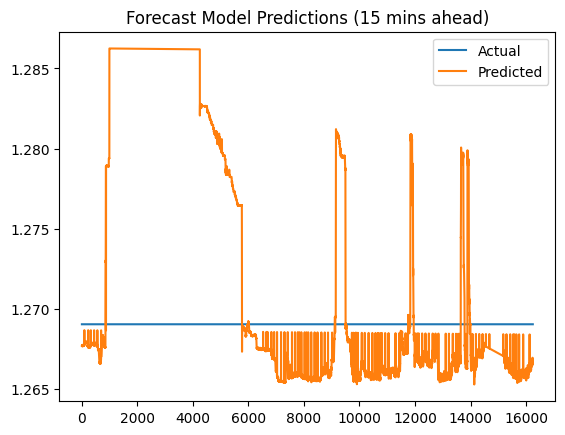

In [ ]:
# Создание временных лагов
lag_steps = 15
for i in range(1, lag_steps + 1):
    full_data[f"lag_{i}"] = full_data['target'].shift(i)

# Удаление пропусков, вызванных лагами
full_data.dropna(inplace=True)

# Новое разделение на признаки и таргет для прогнозной модели
X_lag = full_data.drop(columns=['target'])
y_lag = full_data['target']

# Разделение на тренировочные и тестовые данные
X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test_split(X_lag, y_lag, test_size=0.2, random_state=42, shuffle=False)

# Обучение модели
forecast_model = ElasticNet()
forecast_model.fit(X_train_lag, y_train_lag)

# Оценка качества
forecast_predictions = forecast_model.predict(X_test_lag)
print("MAE:", mean_absolute_error(y_test_lag, forecast_predictions))
print("MSE:", mean_squared_error(y_test_lag, forecast_predictions))

# Визуализация
plt.plot(y_test_lag.values, label="Actual")
plt.plot(forecast_predictions, label="Predicted")
plt.legend()
plt.title("Forecast Model Predictions (15 mins ahead)")
plt.show()

При агригировании на 15 минут, качество предсказаний ещё больше улучшается.

# 4*. Модель для изменения gas_consumption1

MAE: 0.0024460605711691882
MSE: 1.0892979417579077e-05


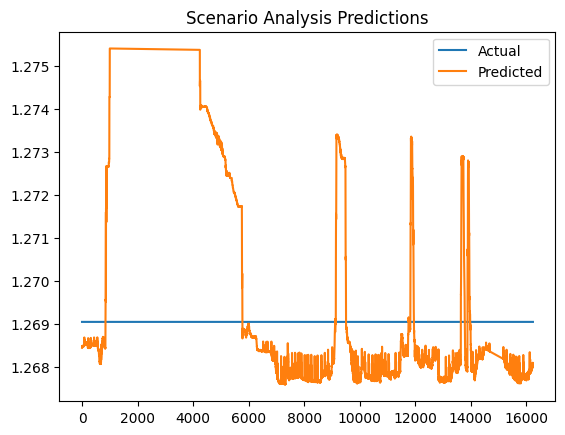

In [ ]:
# Добавление искусственного признака gas_consumption1 + 150
full_data['gas_consumption1_future'] = full_data['gas_consumption1'] + 150

# Создание временных лагов для новой задачи
for i in range(1, lag_steps + 1):
    full_data[f"gas_lag_{i}"] = full_data['gas_consumption1_future'].shift(i)

# Удаление пропусков, вызванных лагами
full_data.dropna(inplace=True)

# Новое разделение на признаки и таргет
X_gas = full_data.drop(columns=['target'])
y_gas = full_data['target']

# Разделение на тренировочные и тестовые данные
X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(X_gas, y_gas, test_size=0.2, random_state=42, shuffle=False)

# Обучение модели
scenario_model = ElasticNet()
scenario_model.fit(X_train_gas, y_train_gas)

# Оценка качества
scenario_predictions = scenario_model.predict(X_test_gas)
print("MAE:", mean_absolute_error(y_test_gas, scenario_predictions))
print("MSE:", mean_squared_error(y_test_gas, scenario_predictions))

# Визуализация
plt.plot(y_test_gas.values, label="Actual")
plt.plot(scenario_predictions, label="Predicted")
plt.legend()
plt.title("Scenario Analysis Predictions")
plt.show()
